In [1]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.chdir('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado')
import pipeline_bm as pipeline
#pd.set_option('display.max_row', 1000000)

pipeline_bm = pipeline.clase_pipeline()

c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Carga Data**

In [73]:
# Open the file in binary mode, remove null bytes, and then decode
with open('G:\\Mi unidad\\SOCOFAR\\0.-Recomendadores-Oficial\\Archivos\\SR_BASE_FINAL_PROD_FEB24.csv', 'rb') as file:
    content = file.read().replace(b'\x00', b'')  # Replace null bytes with nothing

# Convert the binary content to a string and use StringIO to mimic a file object for pandas
from io import StringIO
content_str = StringIO(content.decode('latin'))

# Now use pd.read_csv on the cleaned string data
df = pd.read_csv(content_str, sep=';', encoding='latin',nrows=1000000)
df['RUT_CLIENTE']=((df['SK']+1599)/2).astype(int)

In [74]:
diccionario=pd.read_csv('../diccionario_productos.csv',sep=';',usecols=['CODIGO','UNIDAD_COMERCIAL','MACROCATEGORIA','CATEGORIA_NIVEL_1','CATEGORIA_NIVEL_2_FCV','DESCRIPTOR_LARGO','MARCA'])

In [75]:
excl_otros = [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.isin(['DESPACHO','DESP.A','RETIRO DE RECETA','PROMOCION DTE','HORA VACUNACION','INSUMOS BOLSAS','SIN DESCRIPTOR','AJUSTE POR REDONDEO'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.DESCRIPTOR_LARGO.str.contains('BOLSA PAPEL|BOLS|DESPACHO|PROMOCION|CUPON|INYECCION|MEDICION|MEMBRESIA|REGALO|2020|2021|2022|MUNDIAL')]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.MACROCATEGORIA.isin(['ENFERMERIA ACCESORIOS Y PROCEDIMIENTOS','HOGAR','RECARGAS VARIAS','BEBIDAS Y AGUAS','ACCESORIOS MODA','TECNOLOGIA','AUTOLIQUIDABLES REGALO ARTICULOS VARIOS','INSUMOS MACRO','EQUIPOS QUIRURGICOS','POR CLASIFICAR'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.CATEGORIA_NIVEL_1.isin(['MASCARILLAS PRIMEROS AUXILIOS'])]['CODIGO'])] +\
                          [str(elemento) for elemento in list(diccionario[diccionario.UNIDAD_COMERCIAL.isin(['INSTITUCIONAL'])]['CODIGO'])]
#por código
cods_excluir = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/Archivos/codigos_exclusion.csv',sep=';').excluir.values.tolist() + excl_otros
cods_excluir = [int(cod) for cod in cods_excluir]

diccionario=diccionario[~diccionario.CODIGO.isin(cods_excluir)]

dicc_uam=df['CODIGO_PRODUCTO'].unique()
dicc_productos=diccionario[diccionario.CODIGO.isin(dicc_uam)].CODIGO

In [76]:
df=df[df.CODIGO_PRODUCTO.isin(dicc_productos)]

In [78]:
len(df)

491278

**Muestreo Estratificado**

In [35]:
caracteristicas=pd.read_csv('../SR_CARACTERISTICAS.CSV',sep=';')
df=df.merge(caracteristicas, how='left', on='RUT_CLIENTE')

In [36]:
min = df['EDAD'].min()
max = df['EDAD'].max()
tramos_edad = np.linspace(min, max, num=11)

df['EDAD_TRAMOS'] = pd.cut(df['EDAD'], bins=tramos_edad, include_lowest=True).astype(str)

In [37]:
n_muestra=500000
proporcion=(n_muestra/len(df))*100
print( 'Porcentaje que representa la muestra sobre el dataset completo: '+ str(round(proporcion,2)) + '%')
freq_min=100/proporcion
print('Aparición minima de veces de una combinatoria para ser representada en la muestra: ' +str(int(freq_min)))

Porcentaje que representa la muestra sobre el dataset completo: 50.0%
Aparición minima de veces de una combinatoria para ser representada en la muestra: 2


In [40]:
#Identificar indices de casos con muy baja ocurrencia
conteos = df.groupby(['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']).size()
# Filtrar las combinaciones con menos de "freq_min" apariciones
conteos_filtrados = conteos[conteos >= freq_min]
# Filtrar el DataFrame original para mantener solo las filas con combinaciones frecuentes
df_filtered = df[df.set_index(['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']).index.isin(conteos_filtrados.index)].reset_index(drop=True)

In [41]:
df_filtered

,SK,CODIGO_PRODUCTO,SUM_NRO_PROD,RUT_CLIENTE,GENERO,GSE,COMUNA,EDAD,EDAD_TRAMOS
0,46219693,193020,1,23110646,FEM,E,ANTOFAGASTA,41.0,"(39.4, 49.5]"
1,34302517,100665,1,17152058,FEM,D,QUINTERO,34.0,"(29.3, 39.4]"
2,24732303,259839,1,12366951,FEM,C1b,PARRAL,49.0,"(39.4, 49.5]"
3,27613205,256642,1,13807402,FEM,C3,LAS CONDES,43.0,"(39.4, 49.5]"
4,32647193,6363,1,16324396,MAS,D,CALAMA,37.0,"(29.3, 39.4]"
...,...,...,...,...,...,...,...,...,...
818817,18589911,277430,1,9295755,FEM,D,LA LIGUA,58.0,"(49.5, 59.6]"
818818,45361445,199400,1,22681522,FEM,D,LA CISTERNA,71.0,"(69.7, 79.8]"
818819,32850397,199400,1,16425998,MAS,D,TEMUCO,37.0,"(29.3, 39.4]"
818820,16511527,253352,1,8256563,FEM,C1b,PROVIDENCIA,61.0,"(59.6, 69.7]"


In [42]:
n_muestra=500000
porc_muestra=n_muestra/len(df_filtered) #porcentual
tamaño_muestra = porc_muestra #porcentual
test_size=1-tamaño_muestra ##porcentual
df_estratificado, _ = train_test_split(df_filtered, test_size=test_size, stratify=df_filtered[['GENERO', 'GSE', 'EDAD_TRAMOS','CODIGO_PRODUCTO']])

In [49]:
df=df_estratificado

In [50]:
# Agrupar los productos comprados por cada 'rut' en una lista
sentences = df.groupby('RUT_CLIENTE')['CODIGO_PRODUCTO'].apply(list).tolist()
# Entrenar el modelo Word2Vec con las 'oraciones' de productos
model = Word2Vec(sentences, vector_size=10, window=5, min_count=1, workers=4)

In [5]:
#EN EL SIGUIENTE PASO SE DEBERIA PONDERAR EL PESO (CANTIDAD DE VECES DEL PRODUCTO)

In [ ]:
#CALCULA EL EMBBEDING DEL CLIENTE SEGUN LOS PRODUCTOS QUE HA COMPRADO
client_embeddings = {}
for rut, group in df.groupby('RUT_CLIENTE'):
    products = group['CODIGO_PRODUCTO'].tolist()
    embeddings = []
    for product in products:
        embeddings.append(model.wv[product])
        
    if embeddings:
        client_embeddings[rut] = np.mean(embeddings, axis=0)

In [52]:
client_embeddings_df = pd.DataFrame.from_dict(client_embeddings, orient='index')
client_embeddings_df.reset_index(inplace=True)
client_embeddings_df.columns = ['RUT_CLIENTE'] + [f'embedding_{i}' for i in range(model.vector_size)]        

In [54]:
#min=dicc_productos.quantile(0.2)
#dicc_productos = dicc_productos[dicc_productos > min]
#len(dicc_productos)
df['CODIGO_PRODUCTO'].value_counts()

293450    10041
72203      4774
260536     4549
72202      4501
273362     3814
          ...  
266541        1
290158        1
6060          1
257630        1
288244        1
Name: CODIGO_PRODUCTO, Length: 7862, dtype: int64

In [55]:
len(dicc_productos)

7862

In [56]:
7862*457000

3592934000

In [10]:
dataframe_full = pd.DataFrame()
# Iterar sobre cada producto para construir el dataframe completo
for producto in dicc_productos:
    
    product_embedding = model.wv[producto]
        
    # Crear un DataFrame temporal que repite el embedding del producto para cada cliente
    temp_df = pd.DataFrame([product_embedding], columns=[f'product_embedding_{i}' for i in range(len(product_embedding))])
    temp_df = pd.concat([client_embeddings_df, temp_df.loc[temp_df.index.repeat(client_embeddings_df.shape[0])].reset_index(drop=True)], axis=1)
        
    # Agregar una columna para el producto actual
    temp_df['producto'] = producto
        
    # Concatenar al dataframe completo
    dataframe_full = pd.concat([dataframe_full, temp_df], ignore_index=True)

In [ ]:
# Crear la columna target con "0" en dataframe_full
dataframe_full['target'] = 0

# Realizar un merge entre dataframe_full y df para encontrar los matches
dataframe_full = dataframe_full.merge(df, how='left', left_on=['RUT_CLIENTE', 'producto'], right_on=['RUT_CLIENTE', 'CODIGO_PRODUCTO'])

# Donde haya un match, actualizamos la columna target a "1"
dataframe_full['target'] = dataframe_full['CODIGO_PRODUCTO'].notna().astype(int)

# Ahora matched_df tiene la columna target actualizada correctamente
# Podemos eliminar la columna 'CODIGO_PRODUCTO' ya que solo la necesitábamos para el match
dataframe_full.drop(columns=['CODIGO_PRODUCTO','SK','SUM_NRO_PROD'], inplace=True)

In [ ]:
excluir = ['RUT_CLIENTE', 'target','producto']
columnas_para_redondear = [col for col in dataframe_full.columns if col not in excluir and (dataframe_full[col].dtype == 'float64' or dataframe_full[col].dtype == 'float32')]
dataframe_full[columnas_para_redondear] = dataframe_full[columnas_para_redondear].round(8)
dataframe_full.head()     

,RUT_CLIENTE,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,embedding_8,...,product_embedding_2,product_embedding_3,product_embedding_4,product_embedding_5,product_embedding_6,product_embedding_7,product_embedding_8,product_embedding_9,producto,target
0,1768451,-0.001908,0.077638,-0.066097,-0.070124,-0.081025,0.043250,-0.093846,0.017103,0.080500,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0
1,3052068,-0.055800,-0.085536,0.015003,0.031800,-0.080966,-0.089343,0.091713,0.016438,0.008743,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0
2,3141011,0.063392,0.003837,0.065095,-0.074726,0.036636,-0.098979,0.076107,0.059245,-0.061175,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0
3,3264162,0.099183,-0.090323,-0.043122,0.019289,-0.029974,0.014458,-0.036808,-0.008942,-0.057274,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0
4,3347436,-0.012656,-0.083226,0.030443,-0.088731,-0.026609,-0.093920,-0.004620,-0.078633,0.074140,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0


#### **MODELADO**

In [ ]:
#df_temporal.to_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado/data1.csv',sep=';',index=False)
#pipeline_bm.dataset = pd.read_csv('G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado/data1.csv',delimiter=';')

In [ ]:
pipeline_bm.dataset=dataframe_full

In [ ]:
pipeline_bm.recibe_data(
    tipo = 'dataframe',
    dataset_o_query = '',
    target = 'TARGET',
    delimiter=';' ,
    #muestra = 'MUESTRA',
    #ano_mes = 'FECHA_VENTA',
    rut = 'RUT_CLIENTE', 
    excluir=['PRODUCTO'],
    categoricas=[]
)

Procesando...
cargar previamente pipeline_bm.dataset = nombre_dataframe
________________________________________________________________________________________________________________________
Datos recibidos: OK.
Número de filas y columnas del dataset: (765000, 23)
________________________________________________________________________________________________________________________


In [ ]:
pipeline_bm.dataset.head()

,RUT_CLIENTE,EMBEDDING_0,EMBEDDING_1,EMBEDDING_2,EMBEDDING_3,EMBEDDING_4,EMBEDDING_5,EMBEDDING_6,EMBEDDING_7,EMBEDDING_8,...,PRODUCT_EMBEDDING_2,PRODUCT_EMBEDDING_3,PRODUCT_EMBEDDING_4,PRODUCT_EMBEDDING_5,PRODUCT_EMBEDDING_6,PRODUCT_EMBEDDING_7,PRODUCT_EMBEDDING_8,PRODUCT_EMBEDDING_9,PRODUCTO,TARGET
0,1768451,-0.001908,0.077638,-0.066097,-0.070124,-0.081025,0.043250,-0.093846,0.017103,0.080500,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0
1,3052068,-0.055800,-0.085536,0.015003,0.031800,-0.080966,-0.089343,0.091713,0.016438,0.008743,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0
2,3141011,0.063392,0.003837,0.065095,-0.074726,0.036636,-0.098979,0.076107,0.059245,-0.061175,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0
3,3264162,0.099183,-0.090323,-0.043122,0.019289,-0.029974,0.014458,-0.036808,-0.008942,-0.057274,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0
4,3347436,-0.012656,-0.083226,0.030443,-0.088731,-0.026609,-0.093920,-0.004620,-0.078633,0.074140,...,0.079346,-0.050246,0.051005,0.043513,-0.00699,0.010751,0.057248,-0.066415,287391,0


In [ ]:
len(pipeline_bm.dataset)

765000

In [ ]:
pipeline_bm.separa_muestras(test=0.3)

Separacion de muestras: OK.
________________________________________________________________________________________________________________________


In [ ]:
pipeline_bm.modelacion('RandomForest', perf_eval='f1',ruta_exporta='G:/Mi unidad/SOCOFAR/0.-Recomendadores-Oficial/POS-Cross-Selling/Modelo_Supervisado/modelo_rf.joblib')

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.358 total time=  18.1s
[CV 2/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.364 total time=  24.0s
[CV 3/3] END bootstrap=True, class_weight=balanced, criterion=gini, n_estimators=50, n_jobs=-1, oob_score=True, random_state=0;, score=0.408 total time=  21.4s
best params: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 50, 'n_jobs': -1, 'oob_score': True, 'random_state': 0}
best estimator: RandomForestClassifier(class_weight='balanced', n_estimators=50, n_jobs=-1,
                       oob_score=True, random_state=0)
ROC: 0.6844430375269339
Modelación: OK.
________________________________________________________________________________________________________________________

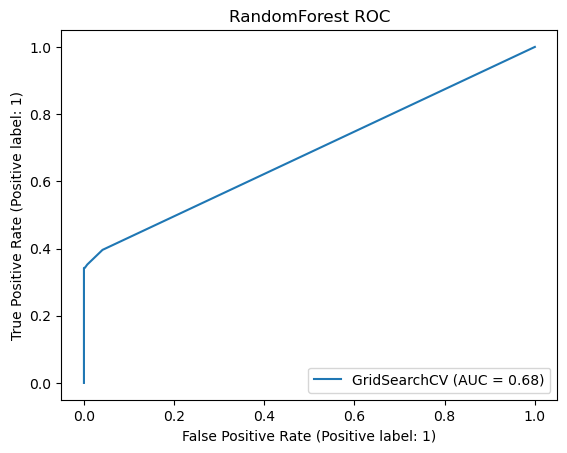

In [ ]:
%matplotlib inline
plot_roc_curve(pipeline_bm.model, pipeline_bm.X_test, pipeline_bm.Y_test)
plt.title(pipeline_bm.algoritmo + ' ROC')
plt.show()

In [ ]:
pipeline_bm.metricas_modelo_optimo()
pipeline_bm.confusion_matrix

"ROC OPTIMO"

sens+espc:  1.3547911402438655
KS:  0.3547911402438656
threshold optimo:  0.019
sensibility:  0.3959731543624161
specificity:  0.9588179858814495
precision:  0.012346970806738517
negative predictive value:  0.9991816061434099
Critical Success Index:  0.01211872239909623
accuracy:  0.958087145969499
f1score:  0.023947234906139016
BalancedAccuracy:  0.6773955701219327


TARGET,0,1
pred,,
0,219763,180
1,9439,118


Lo esperable es que el modelo ajuste extremadamente bien ya que se le proporcionan implicitamente lo productos que compró a través del embbeding del cliente. 
Lo importante acá es que, de cara al uso, la probabilidad hacia un producto no comprado por el cliente será más alta en la medida en que el embbeding del cliente contenga el resto de productos que normalmente los clientes compran junto con el.

no se interprete el acierto de este modelo con la efectividad de las recomendaciones en terminos de "acabar en compra"

**USO DEL MODELO RECOMENDADOR**

- se recibe el cliente y producto buscado
- se calcula el embbeding del cliente como la ponderacion de items historicos + el nuevo
- se calcula la probabilidad de compra para ese embbeding en combinatoria con todos los embbeding de productos existentes
- se seleccionan aquellos "n" con probabilidad más alta (sin compra previa)

In [ ]:
#[rut_cliente,producto-1,...,producto-n]
vector=[1768451,287391,261034,193020]

cliente=vector[0]
productos=vector[1:]

embbeding cliente

In [ ]:
historico=df[df.RUT_CLIENTE==cliente].CODIGO_PRODUCTO.tolist()
total=historico+productos

In [ ]:
embeddings = []
for product in total:
    embeddings.append(model.wv[product])
        
if embeddings:
    client_embedding = np.mean(embeddings, axis=0)

para cada producto se concatena embbeding cliente y producto

In [ ]:
embeddings_df = pd.DataFrame([model.wv[producto] for producto in dicc_productos])
embeddings_df.insert(0, 'producto', dicc_productos)

In [ ]:
df_client_embedding = pd.DataFrame([client_embedding], columns=[f'EMBEDDING_{i}' for i in range(len(client_embedding))])
df_client_embedding = pd.concat([df_client_embedding]*len(embeddings_df), ignore_index=True)
df_client_embedding_final = pd.concat([df_client_embedding, embeddings_df], axis=1)
df_x = df_client_embedding_final.drop(columns=['producto'])
df_productos=pd.DataFrame(df_client_embedding_final.producto)

predicciones y rankeo

In [ ]:
preds=pd.DataFrame(pipeline_bm.model.predict_proba(df_x)[:,1],columns=['PROBABILIDAD'])

In [ ]:
prod_pred=pd.concat([df_productos,preds],axis=1)
prod_pred_final=prod_pred.sort_values(by='PROBABILIDAD',ascending=False).head(5).producto.values.tolist()  

In [ ]:
prod_pred_final

[265086, 16072, 161140, 263047, 193078]